<a href="https://colab.research.google.com/github/Gainward777/YOLOv3-in-Colab/blob/main/YOLOv3_in_Colab_(DarkNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#YOLOv3 colab implementation

##Libs

In [40]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import numpy as np
import cv2

from google.colab.patches import cv2_imshow
from google.colab import files

##Layers

In [2]:
#crutch to simplify calling torch.chat in forward
class EmptyLayer(nn.Module):
    def __init__(self):
        super(EmptyLayer, self).__init__()

In [3]:
class DetectionLayer(nn.Module):
    def __init__(self, anchors):
        super(DetectionLayer, self).__init__()
        self.anchors = anchors

##Helping functions

###Darknet cfg parser

In [4]:
def parse_cfg(cfgfile):
    """
    Takes a configuration file
    
    Returns a list of blocks. Each blocks describes a block in the neural
    network to be built. Block is represented as a dictionary in the list
    
    """

    #open cfg file and split by lines
    file = open(cfgfile, 'r')    
    lines = file.read().split('\n')

    #skip empty lines                        
    lines = [x for x in lines if len(x) > 0]

    #skip comments               
    lines = [x for x in lines if x[0] != '#']

    #skip whitespaces              
    lines = [x.rstrip().lstrip() for x in lines]           

    block = {}

    blocks = []
    for line in lines:      
        #check start of a new block
        if line[0] == "[":
            #if block is not empty, implies it is storing values of previous block.               
            if len(block) != 0:
                #add in blocks list          
                blocks.append(block)
                #re-init the block     
                block = {}              
            block["type"] = line[1:-1].rstrip()     
        else:
            key,value = line.split("=") 
            block[key.rstrip()] = value.lstrip()
    blocks.append(block)

    return blocks

###Assemble network modules

In [5]:
def create_modules(blocks):
    #input pre-processing
    net_info = blocks[0]         
    module_list = nn.ModuleList()
    prev_filters = 3
    output_filters = []

    for index, x in enumerate(blocks[1:]):
        module = nn.Sequential()

        #check the type of block
        #create a new module for the block
        #append to module_list

        #add conv layer
        if (x["type"] == "convolutional"):
            #get complete information
            activation = x["activation"]
            try:
                batch_normalize = int(x["batch_normalize"])
                bias = False
            except:
                batch_normalize = 0
                bias = True

            filters= int(x["filters"])
            padding = int(x["pad"])
            kernel_size = int(x["size"])
            stride = int(x["stride"])

            if padding:
                pad = (kernel_size - 1) // 2
            else:
                pad = 0

            #add the convolutional function
            conv = nn.Conv2d(prev_filters, filters, kernel_size, stride, pad, bias = bias)
            module.add_module("conv_{0}".format(index), conv)

            #add the batch norm it nessesary
            if batch_normalize:
                bn = nn.BatchNorm2d(filters)
                module.add_module("batch_norm_{0}".format(index), bn)

            #add activation if it nessesary            
            if activation == "leaky":
                activn = nn.LeakyReLU(0.1, inplace = True)
                module.add_module("leaky_{0}".format(index), activn)
        
        #add Bilinear2dUpsampling if it's an upsampling layer
        elif (x["type"] == "upsample"):
            stride = int(x["stride"])
            upsample = nn.Upsample(scale_factor = 2, mode = "bilinear")
            module.add_module("upsample_{}".format(index), upsample)

        #add route layer
        elif (x["type"] == "route"):
            x["layers"] = x["layers"].split(',')
            #start of a route
            start = int(x["layers"][0])
            #end, if there exists one.
            try:
                end = int(x["layers"][1])
            except:
                end = 0

            if start > 0: 
                start = start - index
            if end > 0:
                end = end - index
            route = EmptyLayer()
            module.add_module("route_{0}".format(index), route)
            if end < 0:
                filters = output_filters[index + start] + output_filters[index + end]
            else:
                filters= output_filters[index + start]

        #add shortcut (it's skip connection)
        elif x["type"] == "shortcut":
            shortcut = EmptyLayer()
            module.add_module("shortcut_{}".format(index), shortcut)

        #add maxpool layer
        elif x['type'] == "maxpool":          
          size=int(x["size"])
          stride=int(x["stride"])
          padding=int(x["padding"])
          maxpool=nn.MaxPool2d(kernel_size=size, stride=stride, padding=padding)
          module.add_module("maxpool_{}".format(index), maxpool)

        #add "yolo" layer (it's specific detecrion layer)
        elif x["type"] == "yolo":
            mask = x["mask"].split(",")
            mask = [int(x) for x in mask]
    
            anchors = x["anchors"].split(",")
            anchors = [int(a) for a in anchors]
            anchors = [(anchors[i], anchors[i+1]) for i in range(0, len(anchors),2)]
            anchors = [anchors[i] for i in mask]
    
            detection = DetectionLayer(anchors)
            module.add_module("Detection_{}".format(index), detection)
                              
        module_list.append(module)
        prev_filters = filters
        output_filters.append(filters)
        
    return (net_info, module_list)

###Transformation predictions and get final values

####Output pre-transformations, reduction to a single 2-D tensor

In [6]:
def predict_transform(prediction, inp_dim, anchors, num_classes, CUDA = True):
      
    batch_size = prediction.size(0)
    stride =  inp_dim // prediction.size(2)
    grid_size = inp_dim // stride
    bbox_attrs = 5 + num_classes
    num_anchors = len(anchors)
    
    prediction = prediction.view(batch_size, bbox_attrs*num_anchors, grid_size*grid_size)
    prediction = prediction.transpose(1,2).contiguous()
    prediction = prediction.view(batch_size, grid_size*grid_size*num_anchors, bbox_attrs)
    anchors = [(a[0]/stride, a[1]/stride) for a in anchors]

    #sigmoid the  centre_X, centre_Y. and object confidencce
    prediction[:,:,0] = torch.sigmoid(prediction[:,:,0])
    prediction[:,:,1] = torch.sigmoid(prediction[:,:,1])
    prediction[:,:,4] = torch.sigmoid(prediction[:,:,4])
    
    #add the center offsets
    grid = np.arange(grid_size)
    a,b = np.meshgrid(grid, grid)

    x_offset = torch.FloatTensor(a).view(-1,1)
    y_offset = torch.FloatTensor(b).view(-1,1)

    if CUDA:
        x_offset = x_offset.cuda()
        y_offset = y_offset.cuda()

    x_y_offset = torch.cat((x_offset, y_offset), 1).repeat(1,num_anchors).view(-1,2).unsqueeze(0)

    prediction[:,:,:2] += x_y_offset

    #log space transform height and the width
    anchors = torch.FloatTensor(anchors)

    if CUDA:
        anchors = anchors.cuda()

    anchors = anchors.repeat(grid_size*grid_size, 1).unsqueeze(0)
    prediction[:,:,2:4] = torch.exp(prediction[:,:,2:4])*anchors
    
    prediction[:,:,5: 5 + num_classes] = torch.sigmoid((prediction[:,:, 5 : 5 + num_classes]))

    prediction[:,:,:4] *= stride
    
    return prediction

####Thresholding and Non-maximal suppression

In [7]:
def unique(tensor):
    tensor_np = tensor.cpu().numpy()
    unique_np = np.unique(tensor_np)
    unique_tensor = torch.from_numpy(unique_np)
    
    tensor_res = tensor.new(unique_tensor.shape)
    tensor_res.copy_(unique_tensor)
    return tensor_res

In [8]:
def bbox_iou(box1, box2):    
    #returns the IoU of two bounding boxes
    
    #get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]
    
    #get the corrdinates of the intersection rectangle
    inter_rect_x1 =  torch.max(b1_x1, b2_x1)
    inter_rect_y1 =  torch.max(b1_y1, b2_y1)
    inter_rect_x2 =  torch.min(b1_x2, b2_x2)
    inter_rect_y2 =  torch.min(b1_y2, b2_y2)
    
    #get intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)

    #get union area
    b1_area = (b1_x2 - b1_x1 + 1)*(b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1)*(b2_y2 - b2_y1 + 1)
    
    iou = inter_area / (b1_area + b2_area - inter_area)
    
    return iou

In [9]:
def non_max(prediction, confidence, num_classes, nms_conf = 0.4):

    conf_mask = (prediction[:,:,4] > confidence).float().unsqueeze(2)
    prediction = prediction*conf_mask

    #transform bb from center x, center y, height, width to 
    #top-left corner x, top-left corner y, right-bottom corner x, right-bottom corner y
    box_corner = prediction.new(prediction.shape)
    box_corner[:,:,0] = (prediction[:,:,0] - prediction[:,:,2]/2)
    box_corner[:,:,1] = (prediction[:,:,1] - prediction[:,:,3]/2)
    box_corner[:,:,2] = (prediction[:,:,0] + prediction[:,:,2]/2) 
    box_corner[:,:,3] = (prediction[:,:,1] + prediction[:,:,3]/2)
    prediction[:,:,:4] = box_corner[:,:,:4]


    batch_size = prediction.size(0)

    write = False

    for ind in range(batch_size):
        image_pred = prediction[ind]          
        #image tensor
        #confidence threshholding 
        #NMS

        max_conf, max_conf_score = torch.max(image_pred[:,5:5+ num_classes], 1)
        max_conf = max_conf.float().unsqueeze(1)
        max_conf_score = max_conf_score.float().unsqueeze(1)
        seq = (image_pred[:,:5], max_conf, max_conf_score)
        image_pred = torch.cat(seq, 1)

        non_zero_ind =  (torch.nonzero(image_pred[:,4]))
        try:
            image_pred_ = image_pred[non_zero_ind.squeeze(),:].view(-1,7)
        except:
            continue        
        #zero dimension check for PyTorch 0.4 compatibility        
        if image_pred_.shape[0] == 0:
            continue 
        
        #get detected classes (in this case -1 index contains the class index)
        img_classes = unique(image_pred_[:,-1]) 

        for cls in img_classes:
            #perform NMS

            #get the detections with one particular class
            cls_mask = image_pred_*(image_pred_[:,-1] == cls).float().unsqueeze(1)
            class_mask_ind = torch.nonzero(cls_mask[:,-2]).squeeze()
            image_pred_class = image_pred_[class_mask_ind].view(-1,7)
            
            #sort the detections such that the entry with the maximum confidence is at the top            
            conf_sort_index = torch.sort(image_pred_class[:,4], descending = True )[1]
            image_pred_class = image_pred_class[conf_sort_index]
            #detections's number
            idx = image_pred_class.size(0)   

            for i in range(idx):
                #get the IOUs of all boxes that come after the one we are looking at                
                try:
                    ious = bbox_iou(image_pred_class[i].unsqueeze(0), image_pred_class[i+1:])
                except ValueError:
                    break
            
                except IndexError:
                    break
            
                #zero out all the detections that have IoU > treshhold
                iou_mask = (ious < nms_conf).float().unsqueeze(1)
                image_pred_class[i+1:] *= iou_mask       
            
                #zemove the non-zero entries
                non_zero_ind = torch.nonzero(image_pred_class[:,4]).squeeze()
                image_pred_class = image_pred_class[non_zero_ind].view(-1,7)

            #repeat batch_id for each discovered class
            batch_ind = image_pred_class.new(image_pred_class.size(0), 1).fill_(ind)      
            seq = batch_ind, image_pred_class
            
            if not write:
                output = torch.cat(seq,1)
                write = True
            else:
                out = torch.cat(seq,1)
                output = torch.cat((output,out))

    try:
        return output
    except:
        return 0

###Image pre-processing for correct input

In [10]:
def get_input(img):
    #img = cv2.imread(imag)
    #resize to the input dimension
    img = cv2.resize(img, (416,416)) 
    #BGR to RGB, H X W C to C X H X W          
    img_ =  img[:,:,::-1].transpose((2,0,1))
    #add a channel at 0 (for batch), normalise   
    img_ = img_[np.newaxis,:,:,:]/255.0
    #convert to float       
    img_ = torch.from_numpy(img_).float()
    #convert to Variable     
    img_ = Variable(img_)                     
    return img_

###Show results

####Load class names from txt file

In [11]:
#load class names from txt file
def load_classes(namesfile):
    fp = open(namesfile, "r")
    names = fp.read().split("\n")[:-1]
    return names

####Draw bboxes and classes names on image and show it

In [12]:
def show_result(frame, cls_path, outputs):
    img = cv2.imread(frame)   

    classes = load_classes(cls_path) 
    for out in outputs:
        left=int(out[1]/(416/img.shape[1]))
        top=int(out[2]/(416/img.shape[0]))
        right=int(out[3]/(416/img.shape[1]))
        bottom=int(out[4]/(416/img.shape[0]))
        cls_index=int(out[-1])
        
        cv2.rectangle(img, (left, top), (right, bottom), (0,0,255),2)
        name = "{0}".format(classes[cls_index])
        cv2.putText(img, name, (left+6, bottom-6), cv2.FONT_HERSHEY_DUPLEX, 0.8, (255,255,255), 1)

    cv2_imshow(img)



##Main model class

In [13]:
class Yolo_Darknet(nn.Module):
    def __init__(self, cfgfile):
        super(Yolo_Darknet, self).__init__()
        self.blocks = parse_cfg(cfgfile)
        self.net_info, self.module_list = create_modules(self.blocks)
        
    def forward(self, x, CUDA):
        modules = self.blocks[1:]

        #caching the outputs for the route layer
        outputs = {}   
        
        write = 0
        for i, module in enumerate(modules):        
            module_type = (module["type"])
            
            if module_type == "convolutional" or module_type == "upsample" or module_type == "maxpool":
                x = self.module_list[i](x)
    
            elif module_type == "route":
                layers = module["layers"]
                layers = [int(a) for a in layers]
    
                if (layers[0]) > 0:
                    layers[0] = layers[0] - i
    
                if len(layers) == 1:
                    x = outputs[i + (layers[0])]
    
                else:
                    if (layers[1]) > 0:
                        layers[1] = layers[1] - i
                    
                    map1 = outputs[i + layers[0]]
                    map2 = outputs[i + layers[1]]                    
                    
                    x = torch.cat((map1, map2), 1)
                
    
            elif  module_type == "shortcut":
                from_ = int(module["from"])
                x = outputs[i-1] + outputs[i+from_]
    
            elif module_type == 'yolo':        
                anchors = self.module_list[i][0].anchors
                #get input dimensions
                inp_dim = int (self.net_info["height"])
        
                #get number of classes
                num_classes = int (module["classes"])
                        
                #output (predictions) pre-transformation
                x = x.data
                x = predict_transform(x, inp_dim, anchors, num_classes, CUDA)
                
                #if no collector has been intialised
                if not write:              
                    detections = x
                    write = 1                    
        
                else:       
                    detections = torch.cat((detections, x), 1)                    
        
            outputs[i] = x
        
        return detections


    def load_weights(self, weightfile):
        #open the weights file
        fp = open(weightfile, "rb")

        '''
        #The first 5 values are header information 
        1. Major version number
        2. Minor Version Number
        3. Subversion number 
        4,5. Images seen by the network (during training)
        '''

        header = np.fromfile(fp, dtype = np.int32, count = 5)
        self.header = torch.from_numpy(header)
        self.seen = self.header[3]   
        
        weights = np.fromfile(fp, dtype = np.float32)
        
        ptr = 0
        for i in range(len(self.module_list)):
            module_type = self.blocks[i + 1]["type"]
    
            #if module_type is convolutional load weights
            #otherwise ignore.
            
            if module_type == "convolutional":
                model = self.module_list[i]
                try:
                    batch_normalize = int(self.blocks[i+1]["batch_normalize"])
                except:
                    batch_normalize = 0
            
                conv = model[0]
                
                
                if (batch_normalize):
                    bn = model[1]
        
                    #get the number of batch norm layer's weights
                    num_bn_biases = bn.bias.numel()
        
                    #load the weights
                    bn_biases = torch.from_numpy(weights[ptr:ptr + num_bn_biases])
                    ptr += num_bn_biases
        
                    bn_weights = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
        
                    bn_running_mean = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
        
                    bn_running_var = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
        
                    #cast the loaded weights into dims of model weights. 
                    bn_biases = bn_biases.view_as(bn.bias.data)
                    bn_weights = bn_weights.view_as(bn.weight.data)
                    bn_running_mean = bn_running_mean.view_as(bn.running_mean)
                    bn_running_var = bn_running_var.view_as(bn.running_var)
        
                    #copy the data to model
                    bn.bias.data.copy_(bn_biases)
                    bn.weight.data.copy_(bn_weights)
                    bn.running_mean.copy_(bn_running_mean)
                    bn.running_var.copy_(bn_running_var)
                
                else:
                    #number of biases
                    num_biases = conv.bias.numel()
                
                    #load the weights
                    conv_biases = torch.from_numpy(weights[ptr: ptr + num_biases])
                    ptr = ptr + num_biases
                
                    #reshape the loaded weights according to the dims of the model weights
                    conv_biases = conv_biases.view_as(conv.bias.data)
                
                    #finally copy the data
                    conv.bias.data.copy_(conv_biases)
                    
                #get the number of conv layer's weights
                num_weights = conv.weight.numel()
                
                #load the weights for the Convolutional layers
                conv_weights = torch.from_numpy(weights[ptr:ptr+num_weights])
                ptr = ptr + num_weights
                
                conv_weights = conv_weights.view_as(conv.weight.data)
                conv.weight.data.copy_(conv_weights)

        fp.close()

##Test model

In [ ]:
#@title Upload cfg, weights classes (txt) and test image (jpg or png)


uploaded = files.upload()
path_dict={}

up_pathes=[]
keys=['cfg', 'weights', 'jpg', 'png']
up_list=list(uploaded.keys())
for name in up_list:
    ext=name.split('.')[-1]    
    if ext == 'cfg' or ext == 'weights' or ext=='txt':
        path_dict[ext]='/content/'+name
    if ext=='jpg' or ext=='png':
        path_dict['test_image']='/content/'+name

In [43]:
#@title Write addresses, if files already uploaded
path_dict={}
cfg = "/content/drive/MyDrive/yolov3/cfg/yolov3.cfg" #@param {type:"string"}
weights = '/content/drive/MyDrive/yolov3/weights/yolov3.weights' #@param {type:"string"}
test_image = '/content/drive/MyDrive/yolov3/dog-cycle-car.png' #@param {type:"string"}
classes='/content/drive/MyDrive/yolov3/coco_names.txt'#@param {type:"string"}

path_dict['cfg']=cfg
path_dict['weights']=weights
path_dict['test_image']=test_image
path_dict['cls']=classes

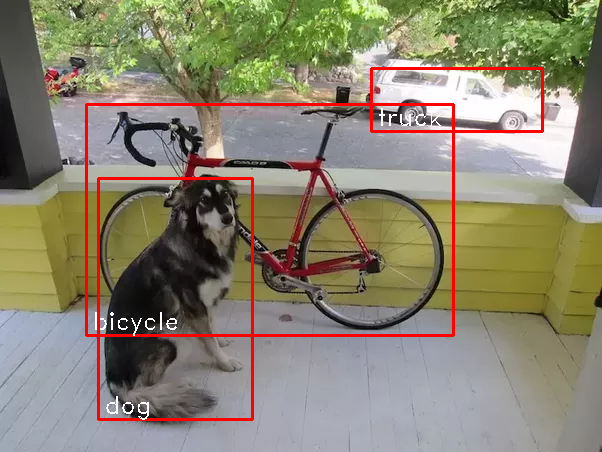

In [44]:
#@title Test
model = Yolo_Darknet(path_dict['cfg'])
model.load_weights(path_dict['weights'])
img = cv2.imread(path_dict['test_image'])
inp = get_input(img)
model.eval()
pred = non_max(model(inp, torch.cuda.is_available()), 0.5, 80)
show_result(path_dict['test_image'],path_dict['cls'], pred)

#Detect from webcam

In [15]:
#@title Libs
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [31]:
#@title Helping functions
# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [45]:
#@title Photo capturing function
def take_photo(model, non_max, classes_path, filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  
  # call our darknet helper on webcam image
  img_w=img.shape[1]
  img_h=img.shape[0]
  width_ratio=img_w/416
  height_ratio=img_h/416
    #print(type(img))

    # create transparent overlay for bounding box
  bbox_array = np.zeros([480,640,4], dtype=np.uint8)

  #inp pre-processing
  img_=get_input(img) 
  
  #get predictions
  outputs = model(img_, torch.cuda.is_available())
  outputs=non_max(outputs, 0.4, 80)
    
  classes = load_classes(classes_path) 
    
  #draw results  
  for out in outputs:   
    
    left=int(out[1]/(416/img_w))
    top=int(out[2]/(416/img_h))
    right=int(out[3]/(416/img_w))
    bottom=int(out[4]/(416/img_h))
    cls_index=int(out[-1])
    name = "{0}".format(classes[cls_index])
    
    cv2.rectangle(img, (left, top), (right, bottom), (0,0,255), 2)
    cv2.putText(img, name,
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      (0,0,255), 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [52]:
#@title Video capturing functions
#JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# start streaming video from webcam and draw bboxes
def video_detect(model, non_max, classes_path):
    video_stream()
    # label for video
    label_html = 'Capturing...'
    # initialze bounding box to empty
    bbox = ''
    count = 0 
    while True:
        js_reply = video_frame(label_html, bbox)
        if not js_reply:
            break

        # convert JS response to OpenCV Image
        img = js_to_image(js_reply["img"])
        img_w=img.shape[1]
        img_h=img.shape[0]

        # create transparent overlay for bounding box
        bbox_array = np.zeros([480,640,4], dtype=np.uint8)

        #inp pre-processing
        img_=get_input(img)
    
        #get predictions
        outputs = model(img_, torch.cuda.is_available())
        outputs=non_max(outputs, 0.4, 80) 
    
        classes = load_classes(classes_path) 
        
        for out in outputs:
        
            left=int(out[1]/(416/img_w))
            top=int(out[2]/(416/img_h))
            right=int(out[3]/(416/img_w))
            bottom=int(out[4]/(416/img_h))
            cls_index=int(out[-1])
        
            bbox_array=cv2.rectangle(bbox_array, (left, top), (right, bottom), (255,0,0),2)
            name = "{0}".format(classes[cls_index])
        
            cv2.putText(bbox_array, name, (left+6, bottom-6), cv2.FONT_HERSHEY_DUPLEX, 0.8, (255,0,0), 2)
      

        bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
        # convert overlay of bbox into bytes
        bbox_bytes = bbox_to_bytes(bbox_array)
        # update bbox so next frame gets new overlay
        bbox = bbox_bytes
    

<IPython.core.display.Javascript object>

Saved to photo1.jpg


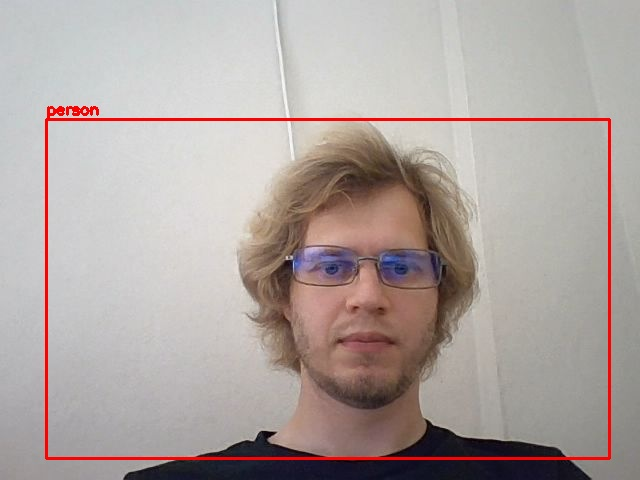

In [48]:
#@title Take photo and detect
try:
  non_m=non_max
  filename = take_photo(model, non_m , path_dict["cls"], 'photo1.jpg')
  print('Saved to {}'.format(filename))
  
  # show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [53]:
#@title Detect on video stream
non_m=non_max
video_detect(model, non_max, path_dict['cls'])

<IPython.core.display.Javascript object>